<a href="https://colab.research.google.com/github/GDLPrabashi/Fashion_store/blob/master/enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow keras matplotlib scikit-learn seaborn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# ============================================
# STEP 1: Mount Google Drive
# ============================================
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/dataset"

Mounted at /content/drive


In [3]:
# ============================================
# STEP 2: Enhanced Data Augmentation
# ============================================
print("📊 Setting up data augmentation...")

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Validation data (only rescale, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    seed=42
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    seed=42
)

print("✅ Classes found:", train_data.class_indices)

📊 Setting up data augmentation...
Found 5919 images belonging to 6 classes.
Found 1477 images belonging to 6 classes.
✅ Classes found: {'Bacterial_Leaf_Blight': 0, 'Brown_Spot': 1, 'Healthy_Rice': 2, 'Non_Rice_Plant': 3, 'Not_Plant': 4, 'Tungro': 5}


In [4]:
 #============================================
# STEP 3: Validate Dataset
# ============================================
print("\n📈 Dataset Information:")
print(f"Total training samples: {train_data.samples}")
print(f"Total validation samples: {val_data.samples}")
print(f"\n📊 Class Distribution (Training):")

class_distribution = {}
for class_name, class_id in train_data.class_indices.items():
    count = (train_data.classes == class_id).sum()
    class_distribution[class_name] = count
    print(f"  {class_name}: {count} samples")


📈 Dataset Information:
Total training samples: 5919
Total validation samples: 1477

📊 Class Distribution (Training):
  Bacterial_Leaf_Blight: 958 samples
  Brown_Spot: 1237 samples
  Healthy_Rice: 868 samples
  Non_Rice_Plant: 999 samples
  Not_Plant: 810 samples
  Tungro: 1047 samples


In [5]:
# ============================================
# STEP 4: Build Model with Transfer Learning
# ============================================
print("\n🔨 Building model...")

# Choose base model (MobileNetV2 or EfficientNetB0)
USE_EFFICIENTNET = False  # Set to True to use EfficientNetB0

if USE_EFFICIENTNET:
    print("Using EfficientNetB0...")
    base_model = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
else:
    print("Using MobileNetV2...")
    base_model = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )

# Freeze base model layers initially
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(train_data.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

print("✅ Model created!")
print(model.summary())


🔨 Building model...
Using MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model created!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,619,590 (9.99 MB)

 Trainable params: 361,606 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [6]:
# ============================================
# STEP 5: Compute Class Weights for Imbalanced Data
# ============================================
print("\n⚖️ Computing class weights...")

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weight_dict = dict(enumerate(class_weights))

print("✅ Class weights:", class_weight_dict)


⚖️ Computing class weights...
✅ Class weights: {0: np.float64(1.029749478079332), 1: np.float64(0.7974939369442199), 2: np.float64(1.1365207373271888), 3: np.float64(0.9874874874874875), 4: np.float64(1.2179012345679012), 5: np.float64(0.9422158548233047)}


In [7]:
# ============================================
# STEP 6: Compile Model
# ============================================
print("\n🔧 Compiling model...")

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


🔧 Compiling model...


In [8]:
# ============================================
# STEP 7: Setup Callbacks
# ============================================
print("\n📞 Setting up callbacks...")

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_rice_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


📞 Setting up callbacks...


In [9]:
# ============================================
# STEP 8: Initial Training (Frozen Base)
# ============================================
print("\n🚀 Phase 1: Training with frozen base model...")

history_initial = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)


🚀 Phase 1: Training with frozen base model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4383 - loss: 1.4425
Epoch 1: val_accuracy improved from -inf to 0.84428, saving model to /content/drive/MyDrive/best_rice_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 1738s 9s/step - accuracy: 0.4392 - loss: 1.4403 - val_accuracy: 0.8443 - val_loss: 0.4704 - learning_rate: 1.0000e-04
Epoch 2/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7970 - loss: 0.5342
Epoch 2: val_accuracy improved from 0.84428 to 0.87204, saving model to /content/drive/MyDrive/best_rice_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.7972 - loss: 0.5339 - val_accuracy: 0.8720 - val_loss: 0.3596 - learning_rate: 1.0000e-04
Epoch 3/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8533 - loss: 0.3904
Epoch 3: val_accuracy improved from 0.87204 to 0.88219, saving model to /content/drive/MyDrive/best_rice_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.8534 - loss: 0.3903 - val_accuracy: 0.8822 - val_loss: 0.3294 - learning_rate: 1.0000e-04
Epoch 4/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8805 - loss: 0.3002
Epoch 4: val_accuracy did not improve from 0.88219
185/185 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.8805 - loss: 0.3001 - val_accuracy: 0.8815 - val_loss: 0.3034 - learning_rate: 1.0000e-04
Epoch 5/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8964 - loss: 0.2641
Epoch 5: val_accuracy improved from 0.88219 to 0.89370, saving model to /content/drive/MyDrive/best_rice_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.8964 - loss: 0.2641 - val_accuracy: 0.8937 - val_loss: 0.2753 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


In [10]:
# ============================================
# STEP 9: Fine-tuning (Unfreeze Last Layers)
# ============================================
print("\n🔓 Phase 2: Fine-tuning with unfrozen layers...")

base_model.trainable = True

# Freeze all but last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Print trainable layers info
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"✅ Trainable layers in base model: {trainable_count}")

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune training
history_finetune = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)


🔓 Phase 2: Fine-tuning with unfrozen layers...
✅ Trainable layers in base model: 30
Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5578 - loss: 1.5105
Epoch 1: val_accuracy improved from 0.89370 to 0.90521, saving model to /content/drive/MyDrive/best_rice_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.5586 - loss: 1.5073 - val_accuracy: 0.9052 - val_loss: 0.2238 - learning_rate: 1.0000e-05
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8847 - loss: 0.3224
Epoch 2: val_accuracy improved from 0.90521 to 0.91740, saving model to /content/drive/MyDrive/best_rice_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.8847 - loss: 0.3223 - val_accuracy: 0.9174 - val_loss: 0.2260 - learning_rate: 1.0000e-05
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9037 - loss: 0.2710
Epoch 3: val_accuracy improved from 0.91740 to 0.92620, saving model to /content/drive/MyDrive/best_rice_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.9038 - loss: 0.2709 - val_accuracy: 0.9262 - val_loss: 0.2208 - learning_rate: 1.0000e-05
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9121 - loss: 0.2307
Epoch 4: val_accuracy did not improve from 0.92620
185/185 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.9121 - loss: 0.2307 - val_accuracy: 0.9194 - val_loss: 0.2403 - learning_rate: 1.0000e-05
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9273 - loss: 0.2029
Epoch 5: val_accuracy improved from 0.92620 to 0.92823, saving model to /content/drive/MyDrive/best_rice_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.9273 - loss: 0.2028 - val_accuracy: 0.9282 - val_loss: 0.2054 - learning_rate: 1.0000e-05
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9367 - loss: 0.1763
Epoch 6: val_accuracy did not improve from 0.92823
185/185 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.9367 - loss: 0.1763 - val_accuracy: 0.9276 - val_loss: 0.1951 - learning_rate: 1.0000e-05
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9401 - loss: 0.1585
Epoch 7: val_accuracy did not improve from 0.92823
185/185 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.9401 - loss: 0.1584 - val_accuracy: 0.9215 - val_loss: 0.2048 - learning_rate: 1.0000e-05
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9499 - loss: 0.1330
Epoch 8: val_accuracy improved from 0.92823 to 0.93907, saving model to /content/drive/MyDrive/best_rice_model.h5


185/185 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.9499 - loss: 0.1330 - val_accuracy: 0.9391 - val_loss: 0.1797 - learning_rate: 1.0000e-05
Epoch 9/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9512 - loss: 0.1235
Epoch 9: val_accuracy did not improve from 0.93907
185/185 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.9512 - loss: 0.1235 - val_accuracy: 0.9303 - val_loss: 0.2031 - learning_rate: 1.0000e-05
Epoch 10/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9587 - loss: 0.1111
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 10: val_accuracy did not improve from 0.93907
185/185 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.9587 - loss: 0.1111 - val_accuracy: 0.9282 - val_loss: 0.1879 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 8.



📊 Plotting training history...


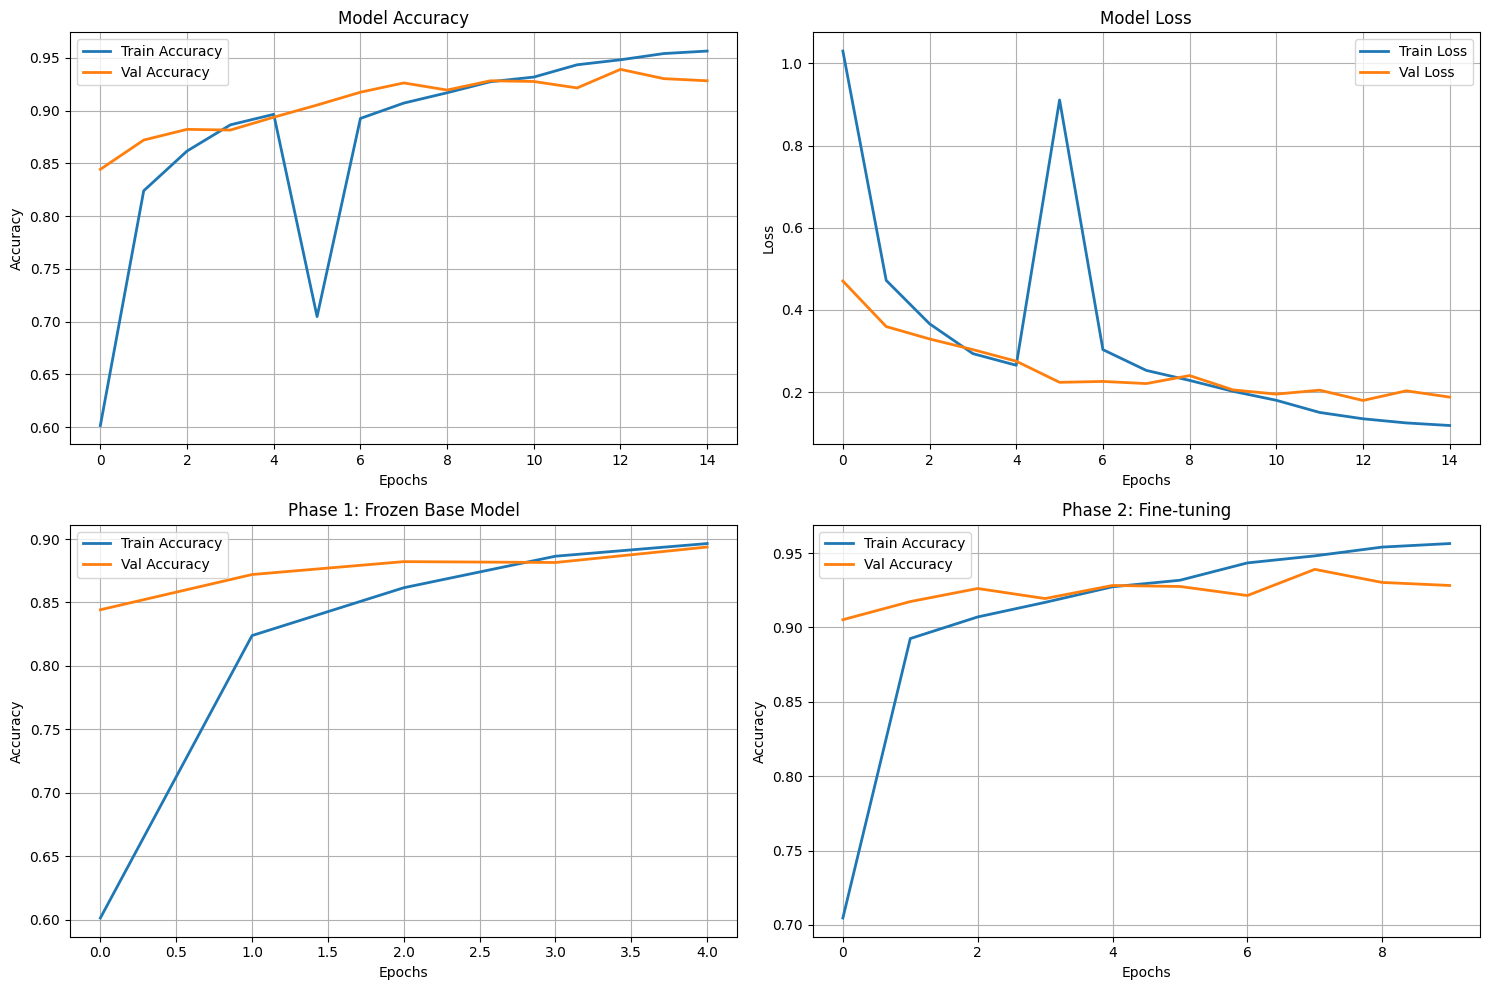

In [11]:
# ============================================
# STEP 10: Plot Training History
# ============================================
print("\n📊 Plotting training history...")

def plot_history(history_initial, history_finetune):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Combine histories
    all_accuracy = history_initial.history['accuracy'] + history_finetune.history['accuracy']
    all_val_accuracy = history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy']
    all_loss = history_initial.history['loss'] + history_finetune.history['loss']
    all_val_loss = history_initial.history['val_loss'] + history_finetune.history['val_loss']

    # Plot accuracy
    axes[0, 0].plot(all_accuracy, label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(all_val_accuracy, label='Val Accuracy', linewidth=2)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid()

    # Plot loss
    axes[0, 1].plot(all_loss, label='Train Loss', linewidth=2)
    axes[0, 1].plot(all_val_loss, label='Val Loss', linewidth=2)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].legend()
    axes[0, 1].grid()

    # Plot initial phase only
    axes[1, 0].plot(history_initial.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1, 0].plot(history_initial.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Phase 1: Frozen Base Model')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # Plot fine-tuning phase only
    axes[1, 1].plot(history_finetune.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1, 1].plot(history_finetune.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Phase 2: Fine-tuning')
    axes[1, 1].legend()
    axes[1, 1].grid()

    plt.tight_layout()
    plt.show()

plot_history(history_initial, history_finetune)

In [12]:
# ============================================
# STEP 11: Evaluate Model
# ============================================
print("\n📋 Evaluating model on validation set...")

loss, acc = model.evaluate(val_data)
print(f"✅ Validation Accuracy: {acc*100:.2f}%")
print(f"✅ Validation Loss: {loss:.4f}")



📋 Evaluating model on validation set...
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9222 - loss: 0.2157
✅ Validation Accuracy: 92.96%
✅ Validation Loss: 0.1987



🔍 Generating detailed evaluation metrics...
47/47 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step

📊 Classification Report:
                       precision    recall  f1-score   support

Bacterial_Leaf_Blight       0.16      0.16      0.16       239
           Brown_Spot       0.20      0.17      0.18       309
         Healthy_Rice       0.14      0.16      0.15       217
       Non_Rice_Plant       0.16      0.16      0.16       249
            Not_Plant       0.12      0.12      0.12       202
               Tungro       0.17      0.18      0.17       261

             accuracy                           0.16      1477
            macro avg       0.16      0.16      0.16      1477
         weighted avg       0.16      0.16      0.16      1477


🔲 Generating confusion matrix...


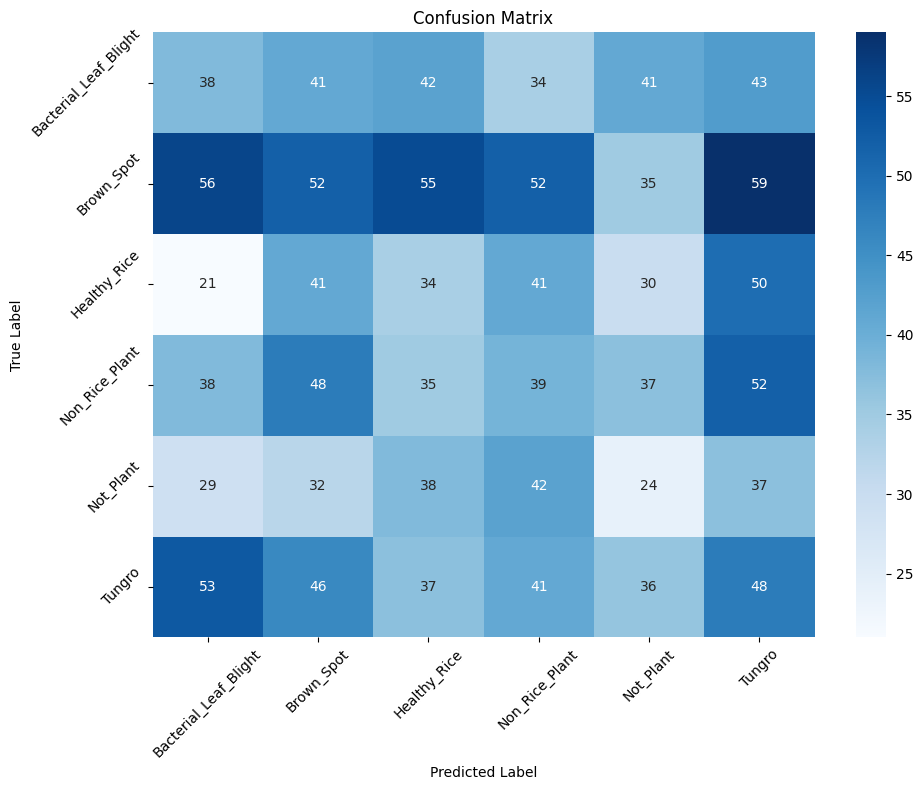

In [13]:
# ============================================
# STEP 12: Detailed Evaluation with Confusion Matrix
# ============================================
print("\n🔍 Generating detailed evaluation metrics...")

# Get predictions on validation set
val_data.reset()
y_true = val_data.classes
y_pred_probs = model.predict(val_data)
y_pred = y_pred_probs.argmax(axis=1)

# Get class names
class_names = list(train_data.class_indices.keys())

# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
print("\n🔲 Generating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# ============================================
# STEP 13: Prediction Function with Confidence
# ============================================
def predict_with_confidence(img_path, img_size=(224, 224)):
    """
    Predict disease class and show confidence scores
    """
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)[0]
    class_index = prediction.argmax()
    confidence = prediction[class_index]
    class_label = class_names[class_index]

    print(f"\n{'='*50}")
    print(f"🌿 Predicted Class: {class_label}")
    print(f"📊 Confidence: {confidence*100:.2f}%")
    print(f"\n📈 All Predictions:")
    print(f"{'='*50}")

    # Sort predictions by confidence
    sorted_indices = np.argsort(prediction)[::-1]
    for idx in sorted_indices:
        print(f"  {class_names[idx]}: {prediction[idx]*100:.2f}%")

    print(f"{'='*50}\n")

    return class_label, confidence

In [16]:
# ============================================
# STEP 14: Test Predictions
# ============================================
print("\n🧪 Testing predictions on sample images...")

# Test on a few images
test_images = [
    "/content/OIP.jfif",
    #  "/content/OIP.jfif"
]

for img_path in test_images:
    try:
        predict_with_confidence(img_path)
    except FileNotFoundError:
        print(f"⚠️ Image not found: {img_path}")


🧪 Testing predictions on sample images...

🌿 Predicted Class: Not_Plant
📊 Confidence: 42.73%

📈 All Predictions:
  Not_Plant: 42.73%
  Healthy_Rice: 38.14%
  Non_Rice_Plant: 9.55%
  Tungro: 5.81%
  Bacterial_Leaf_Blight: 3.63%
  Brown_Spot: 0.14%



In [17]:
# # ============================================
# # STEP 15: Save Models
# # ============================================
# print("\n💾 Saving models...")

# # Save as HDF5
# model.save("/content/drive/MyDrive/rice_disease_model.h5")
# print("✅ Saved: rice_disease_model.h5")

# model.save("/content/drive/MyDrive/rice_disease_model.keras")
# print("✅ Saved: rice_disease_model.keras")


# # Save as SavedModel format (better compatibility)
# model.save("/content/drive/MyDrive/rice_disease_model")
# print("✅ Saved: rice_disease_model (SavedModel format)")

# print("\n🎉 Training complete!")

# ============================================
# STEP 15: Save Models
# ============================================
print("\n💾 Saving models...")

# Save as HDF5 (legacy)
model.save("/content/drive/MyDrive/rice_disease_model.h5")
print("✅ Saved: rice_disease_model.h5")

# Save as new Keras format (recommended)
model.save("/content/drive/MyDrive/rice_disease_model.keras")
print("✅ Saved: rice_disease_model.keras")

# Export for TensorFlow Serving / TFLite
model.export("/content/drive/MyDrive/rice_disease_model")
print("✅ Exported: rice_disease_model (SavedModel format)")

print("\n🎉 Training complete!")



💾 Saving models...
✅ Saved: rice_disease_model.h5
✅ Saved: rice_disease_model.keras
Saved artifact at '/content/drive/MyDrive/rice_disease_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134434756074896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134434756075664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134434756078160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134434756077776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134434756076624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134434756078352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134434756076816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134434756078928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134434756078544: TensorSpec(shape=(), dtype=

In [18]:
# ============================================
# CORRECTED EVALUATION CODE
# ============================================
print("🔄 Starting Proper Model Evaluation...\n")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

🔄 Starting Proper Model Evaluation...



In [19]:
# ============================================
# STEP 1: Load the Best Model
# ============================================
print("📂 Loading best model...")

model_path = "/content/drive/MyDrive/best_rice_model.h5"


📂 Loading best model...


In [20]:
# Check if file exists
if os.path.exists(model_path):
    file_size = os.path.getsize(model_path) / 1e6
    print(f"✅ Model found! Size: {file_size:.2f} MB")
else:
    print(f"❌ Model not found at: {model_path}")
    print("Available files:")
    print(os.listdir("/content/drive/MyDrive/"))

# Load the model
model = keras.models.load_model(model_path)
print("✅ Model loaded successfully!\n")

✅ Model found! Size: 26.16 MB


✅ Model loaded successfully!



In [21]:
# ============================================
# STEP 2: Recreate Validation Data Generator
# ============================================
print("📊 Setting up validation data generator...")

data_dir = "/content/drive/MyDrive/dataset"
img_size = (224, 224)
batch_size = 32

# Create fresh validation generator (NO AUGMENTATION, ONLY RESCALING)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_data = val_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,  # IMPORTANT: Don't shuffle for evaluation
    seed=42
)

print(f"✅ Found {val_data.samples} validation images")
print(f"✅ Classes: {val_data.class_indices}\n")

# Store class names
class_names = list(val_data.class_indices.keys())
print(f"Class names: {class_names}\n")

📊 Setting up validation data generator...
Found 1477 images belonging to 6 classes.
✅ Found 1477 validation images
✅ Classes: {'Bacterial_Leaf_Blight': 0, 'Brown_Spot': 1, 'Healthy_Rice': 2, 'Non_Rice_Plant': 3, 'Not_Plant': 4, 'Tungro': 5}

Class names: ['Bacterial_Leaf_Blight', 'Brown_Spot', 'Healthy_Rice', 'Non_Rice_Plant', 'Not_Plant', 'Tungro']



In [22]:
# ============================================
# STEP 3: Sanity Check - Verify Data Normalization
# ============================================
print("🔍 Sanity Check - Data Preprocessing...")

sample_batch = next(val_data)
print(f"✅ Image values range: {sample_batch[0].min():.3f} to {sample_batch[0].max():.3f}")
print(f"   (Should be 0.000 to 1.000)")
print(f"✅ Batch shape: {sample_batch[0].shape}")
print(f"✅ Label shape: {sample_batch[1].shape}")
print(f"   (Should be (batch_size, num_classes))\n")

# Reset after sanity check
val_data.reset()


🔍 Sanity Check - Data Preprocessing...
✅ Image values range: 0.000 to 1.000
   (Should be 0.000 to 1.000)
✅ Batch shape: (32, 224, 224, 3)
✅ Label shape: (32, 6)
   (Should be (batch_size, num_classes))



In [23]:
# ============================================
# STEP 4: Model Evaluation
# ============================================
print("📈 Evaluating model on validation set...\n")

loss, accuracy = model.evaluate(val_data, verbose=1)

print(f"\n{'='*60}")
print(f"🎯 VALIDATION RESULTS:")
print(f"{'='*60}")
print(f"   Accuracy: {accuracy*100:.2f}%")
print(f"   Loss: {loss:.4f}")
print(f"{'='*60}\n")

📈 Evaluating model on validation set...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8917 - loss: 0.3491

🎯 VALIDATION RESULTS:
   Accuracy: 92.42%
   Loss: 0.2398



In [24]:
 #============================================
# STEP 5: Generate Predictions
# ============================================
print("🔮 Generating predictions for detailed analysis...\n")

# Reset generator to ensure order
val_data.reset()

# Get predictions
y_pred_probs = model.predict(val_data, verbose=1)
y_pred = y_pred_probs.argmax(axis=1)

# Get true labels (must match prediction length)
y_true = val_data.classes
total_samples = len(y_pred)
y_true = y_true[:total_samples]  # Ensure same length

print(f"\n✅ Generated {len(y_pred)} predictions")
print(f"✅ True labels: {len(y_true)}")

🔮 Generating predictions for detailed analysis...

47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step

✅ Generated 1477 predictions
✅ True labels: 1477


In [25]:
# ============================================
# STEP 6: Detailed Classification Report
# ============================================
print(f"\n{'='*60}")
print("📊 DETAILED CLASSIFICATION REPORT")
print(f"{'='*60}\n")

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)
print(report)

# Also get per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_true,
    y_pred,
    labels=range(len(class_names))
)

print(f"\n{'='*60}")
print("📈 PER-CLASS PERFORMANCE SUMMARY")
print(f"{'='*60}")
for i, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    print(f"  Precision: {precision[i]*100:.2f}%")
    print(f"  Recall:    {recall[i]*100:.2f}%")
    print(f"  F1-Score:  {f1[i]*100:.2f}%")
    print(f"  Samples:   {support[i]}")



📊 DETAILED CLASSIFICATION REPORT

                       precision    recall  f1-score   support

Bacterial_Leaf_Blight     0.9328    0.9289    0.9308       239
           Brown_Spot     0.9455    0.8414    0.8904       309
         Healthy_Rice     0.9293    0.7880    0.8529       217
       Non_Rice_Plant     1.0000    1.0000    1.0000       249
            Not_Plant     0.9951    1.0000    0.9975       202
               Tungro     0.7957    1.0000    0.8862       261

             accuracy                         0.9242      1477
            macro avg     0.9331    0.9264    0.9263      1477
         weighted avg     0.9306    0.9242    0.9238      1477


📈 PER-CLASS PERFORMANCE SUMMARY

Bacterial_Leaf_Blight:
  Precision: 93.28%
  Recall:    92.89%
  F1-Score:  93.08%
  Samples:   239

Brown_Spot:
  Precision: 94.55%
  Recall:    84.14%
  F1-Score:  89.04%
  Samples:   309

Healthy_Rice:
  Precision: 92.93%
  Recall:    78.80%
  F1-Score:  85.29%
  Samples:   217

Non_Rice_Plant:


🔲 CONFUSION MATRIX



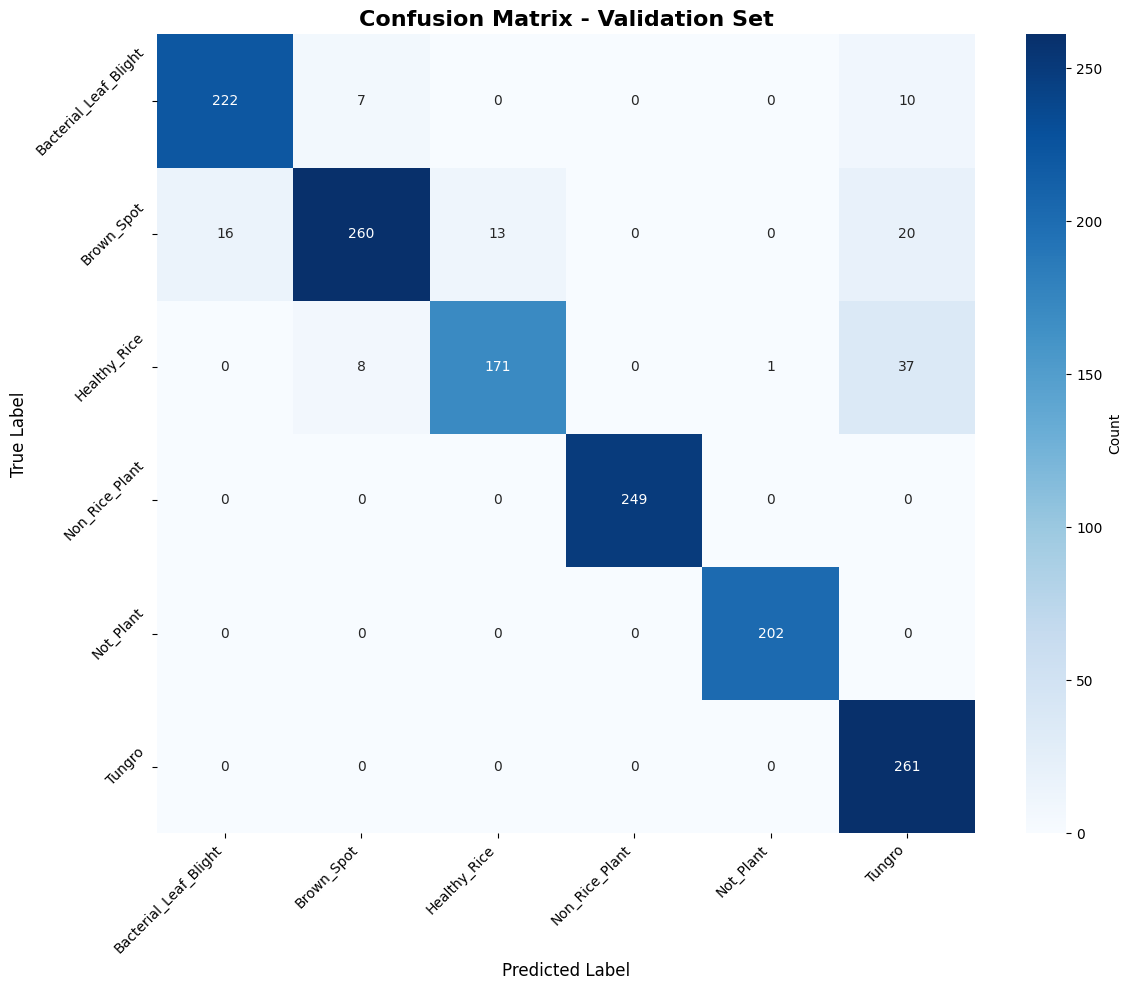


Confusion Matrix (rows=true, cols=predicted):
[[222   7   0   0   0  10]
 [ 16 260  13   0   0  20]
 [  0   8 171   0   1  37]
 [  0   0   0 249   0   0]
 [  0   0   0   0 202   0]
 [  0   0   0   0   0 261]]


In [26]:
# ============================================
# STEP 7: Confusion Matrix
# ============================================
print(f"\n{'='*60}")
print("🔲 CONFUSION MATRIX")
print(f"{'='*60}\n")

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Print confusion matrix numerically
print("\nConfusion Matrix (rows=true, cols=predicted):")
print(cm)


In [27]:
# ============================================
# STEP 8: Analyze Misclassifications
# ============================================
print(f"\n{'='*60}")
print("🔍 MISCLASSIFICATION ANALYSIS")
print(f"{'='*60}\n")

# Find worst performing classes
for i, class_name in enumerate(class_names):
    class_total = support[i]
    class_correct = cm[i, i]
    class_wrong = class_total - class_correct
    class_accuracy = (class_correct / class_total) * 100 if class_total > 0 else 0

    print(f"{class_name}:")
    print(f"  Correct: {class_correct}/{class_total} ({class_accuracy:.2f}%)")
    print(f"  Wrong:   {class_wrong}/{class_total}")

    # Show what it's confused with
    if class_wrong > 0:
        confused_with = []
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confused_with.append(f"{class_names[j]} ({cm[i, j]})")
        if confused_with:
            print(f"  Confused with: {', '.join(confused_with)}")
    print()



🔍 MISCLASSIFICATION ANALYSIS

Bacterial_Leaf_Blight:
  Correct: 222/239 (92.89%)
  Wrong:   17/239
  Confused with: Brown_Spot (7), Tungro (10)

Brown_Spot:
  Correct: 260/309 (84.14%)
  Wrong:   49/309
  Confused with: Bacterial_Leaf_Blight (16), Healthy_Rice (13), Tungro (20)

Healthy_Rice:
  Correct: 171/217 (78.80%)
  Wrong:   46/217
  Confused with: Brown_Spot (8), Not_Plant (1), Tungro (37)

Non_Rice_Plant:
  Correct: 249/249 (100.00%)
  Wrong:   0/249

Not_Plant:
  Correct: 202/202 (100.00%)
  Wrong:   0/202

Tungro:
  Correct: 261/261 (100.00%)
  Wrong:   0/261



In [32]:
# Weighted training focusing on problem classes
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Retrain Phase 2 with weights
history_phase2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

NameError: name 'y_train' is not defined

In [28]:
# ============================================
# STEP 9: Prediction Function for Single Images
# ============================================
def predict_image(img_path, show_plot=True):
    """
    Predict disease class for a single image
    """
    # Load and preprocess image
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # CRITICAL: Rescale!
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array, verbose=0)[0]
    predicted_class_idx = predictions.argmax()
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[predicted_class_idx]

    # Print results
    print(f"\n{'='*60}")
    print(f"📸 Image: {os.path.basename(img_path)}")
    print(f"{'='*60}")
    print(f"🎯 Predicted: {predicted_class}")
    print(f"📊 Confidence: {confidence*100:.2f}%\n")
    print(f"All Predictions:")
    print(f"{'-'*60}")

    # Sort by confidence
    sorted_indices = np.argsort(predictions)[::-1]
    for idx in sorted_indices:
        bar = '█' * int(predictions[idx] * 50)
        print(f"  {class_names[idx]:20s} {predictions[idx]*100:6.2f}% {bar}")
    print(f"{'='*60}\n")

    # Plot if requested
    if show_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Show image
        ax1.imshow(img)
        ax1.axis('off')
        ax1.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence*100:.2f}%',
                     fontsize=12, fontweight='bold')

        # Show prediction probabilities
        colors = ['green' if i == predicted_class_idx else 'gray'
                 for i in range(len(class_names))]
        ax2.barh(class_names, predictions, color=colors)
        ax2.set_xlabel('Probability', fontsize=11)
        ax2.set_title('Class Probabilities', fontsize=12, fontweight='bold')
        ax2.set_xlim([0, 1])

        plt.tight_layout()
        plt.show()

    return predicted_class, confidence



🧪 TESTING ON SAMPLE IMAGES

Testing one image from each class...

Testing Bacterial_Leaf_Blight...

📸 Image: aug_0_1018.jpg
🎯 Predicted: Bacterial_Leaf_Blight
📊 Confidence: 99.98%

All Predictions:
------------------------------------------------------------
  Bacterial_Leaf_Blight  99.98% █████████████████████████████████████████████████
  Brown_Spot             0.02% 
  Not_Plant              0.00% 
  Tungro                 0.00% 
  Healthy_Rice           0.00% 
  Non_Rice_Plant         0.00% 



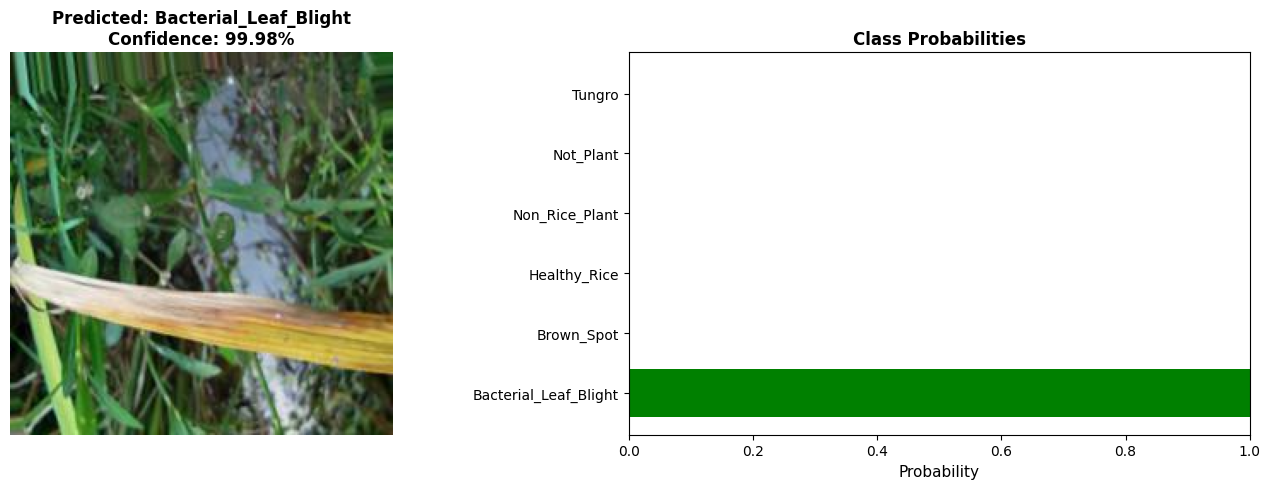

Testing Brown_Spot...

📸 Image: aug_0_2641.jpg
🎯 Predicted: Brown_Spot
📊 Confidence: 98.99%

All Predictions:
------------------------------------------------------------
  Brown_Spot            98.99% █████████████████████████████████████████████████
  Bacterial_Leaf_Blight   0.57% 
  Healthy_Rice           0.26% 
  Tungro                 0.16% 
  Non_Rice_Plant         0.02% 
  Not_Plant              0.01% 



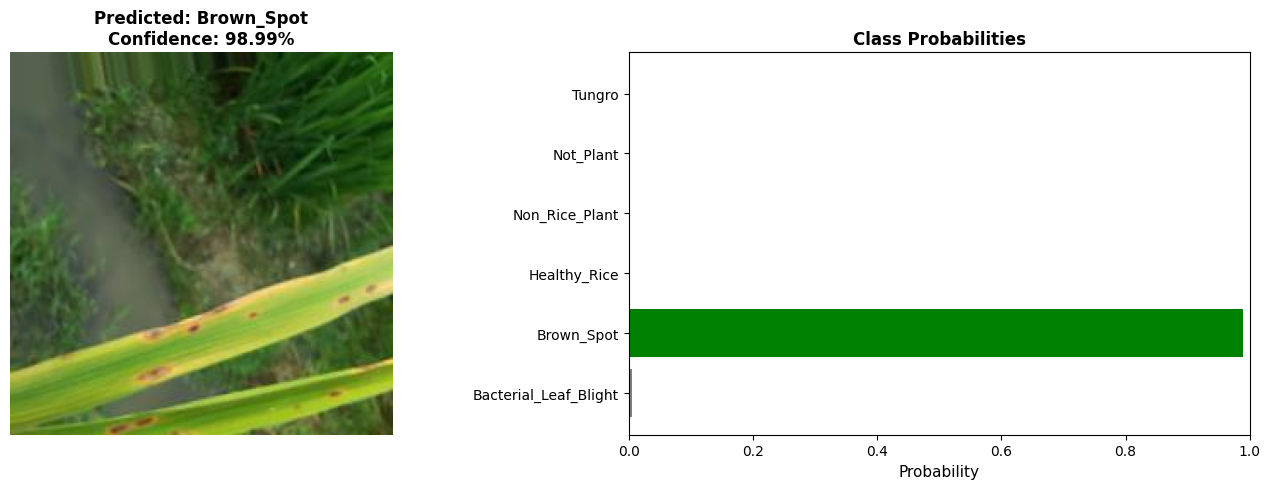

Testing Healthy_Rice...

📸 Image: Healthy_rice_leaf (169).jpg
🎯 Predicted: Healthy_Rice
📊 Confidence: 63.38%

All Predictions:
------------------------------------------------------------
  Healthy_Rice          63.38% ███████████████████████████████
  Brown_Spot            34.61% █████████████████
  Tungro                 1.21% 
  Not_Plant              0.34% 
  Bacterial_Leaf_Blight   0.33% 
  Non_Rice_Plant         0.14% 



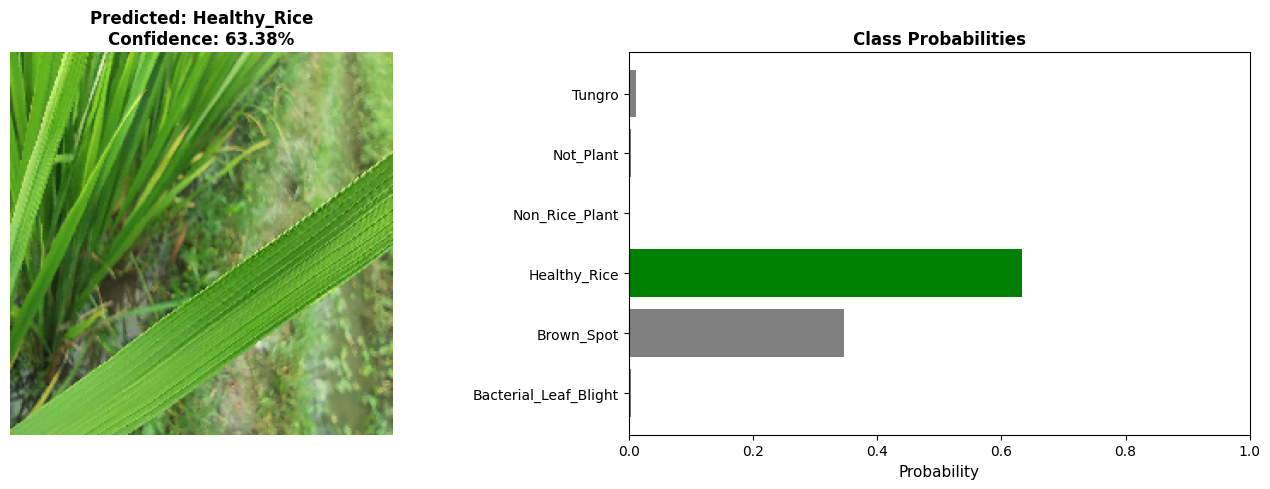

Testing Non_Rice_Plant...

📸 Image: eb69cd1d-ab61-44cf-b8d0-2e6317fd3043___GCREC_Bact.Sp 2998.JPG
🎯 Predicted: Non_Rice_Plant
📊 Confidence: 100.00%

All Predictions:
------------------------------------------------------------
  Non_Rice_Plant       100.00% █████████████████████████████████████████████████
  Tungro                 0.00% 
  Not_Plant              0.00% 
  Brown_Spot             0.00% 
  Bacterial_Leaf_Blight   0.00% 
  Healthy_Rice           0.00% 



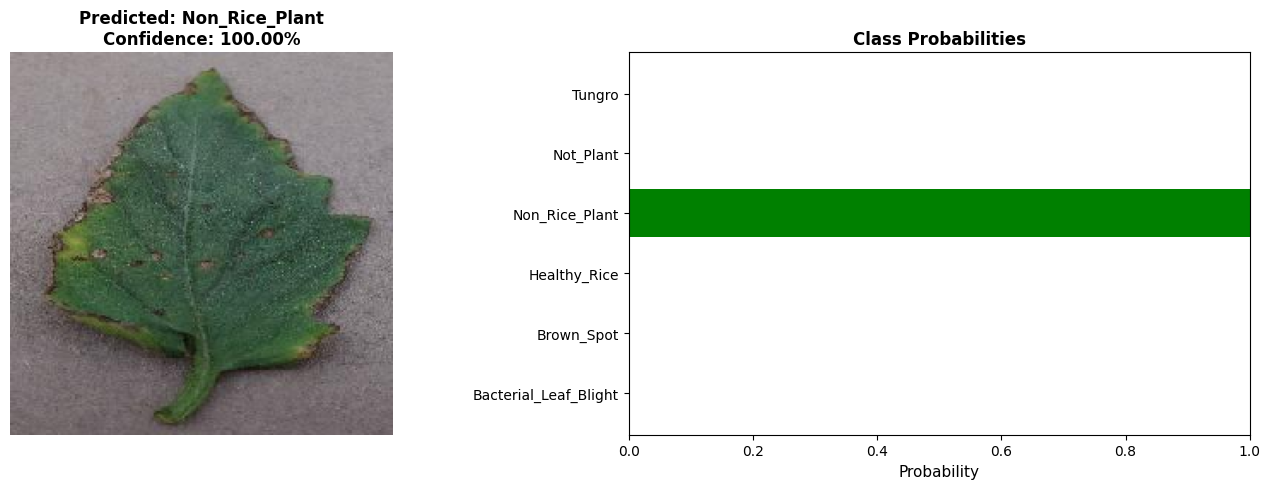

Testing Not_Plant...

📸 Image: 00bfcd25320fd354.jpg
🎯 Predicted: Not_Plant
📊 Confidence: 100.00%

All Predictions:
------------------------------------------------------------
  Not_Plant            100.00% █████████████████████████████████████████████████
  Healthy_Rice           0.00% 
  Non_Rice_Plant         0.00% 
  Tungro                 0.00% 
  Brown_Spot             0.00% 
  Bacterial_Leaf_Blight   0.00% 



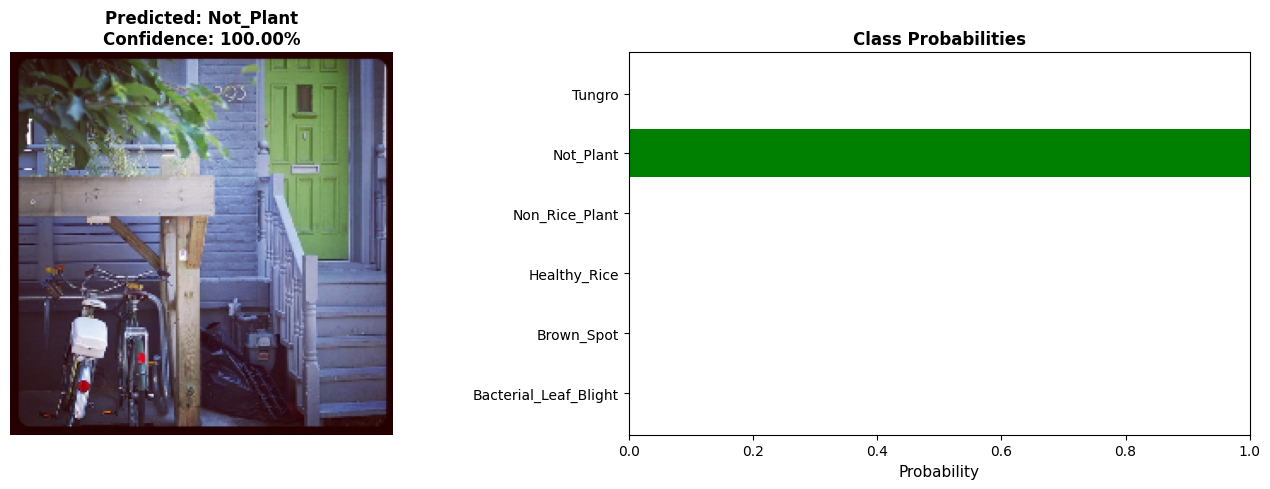

Testing Tungro...

📸 Image: TUNGRO2_171.JPG
🎯 Predicted: Tungro
📊 Confidence: 100.00%

All Predictions:
------------------------------------------------------------
  Tungro               100.00% █████████████████████████████████████████████████
  Healthy_Rice           0.00% 
  Non_Rice_Plant         0.00% 
  Brown_Spot             0.00% 
  Not_Plant              0.00% 
  Bacterial_Leaf_Blight   0.00% 



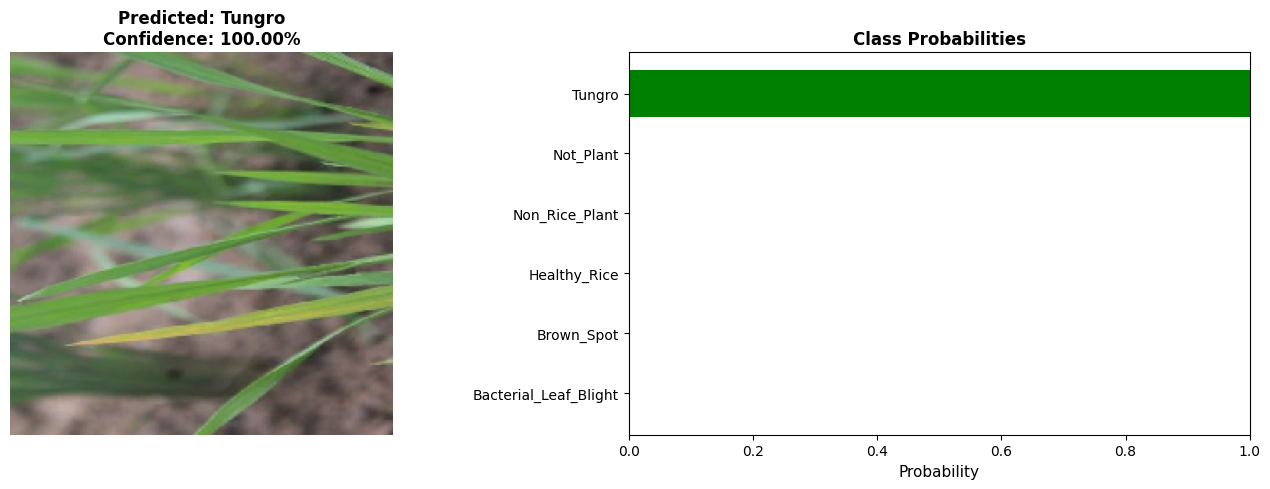

In [29]:
# ============================================
# STEP 10: Test on Sample Images
# ============================================
print(f"\n{'='*60}")
print("🧪 TESTING ON SAMPLE IMAGES")
print(f"{'='*60}\n")

# Test one image from each class
print("Testing one image from each class...\n")

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)

    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if images:
            # Pick first image
            test_img_path = os.path.join(class_path, images[0])
            print(f"Testing {class_name}...")
            predict_image(test_img_path, show_plot=True)
        else:
            print(f"⚠️ No images found in {class_name}")
    else:
        print(f"⚠️ Directory not found: {class_path}")


In [30]:
# ============================================
# STEP 11: Final Summary
# ============================================
print(f"\n{'='*60}")
print("📋 EVALUATION SUMMARY")
print(f"{'='*60}")
print(f"Total samples evaluated: {total_samples}")
print(f"Overall accuracy: {accuracy*100:.2f}%")
print(f"Average precision: {precision.mean()*100:.2f}%")
print(f"Average recall: {recall.mean()*100:.2f}%")
print(f"Average F1-score: {f1.mean()*100:.2f}%")
print(f"{'='*60}")

# Find best and worst performing classes
best_class_idx = f1.argmax()
worst_class_idx = f1.argmin()

print(f"\n🏆 Best performing class: {class_names[best_class_idx]} (F1: {f1[best_class_idx]*100:.2f}%)")
print(f"⚠️  Worst performing class: {class_names[worst_class_idx]} (F1: {f1[worst_class_idx]*100:.2f}%)")

print(f"\n{'='*60}")
print("✅ EVALUATION COMPLETE!")
print(f"{'='*60}\n")



📋 EVALUATION SUMMARY
Total samples evaluated: 1477
Overall accuracy: 92.42%
Average precision: 93.31%
Average recall: 92.64%
Average F1-score: 92.63%

🏆 Best performing class: Non_Rice_Plant (F1: 100.00%)
⚠️  Worst performing class: Healthy_Rice (F1: 85.29%)

✅ EVALUATION COMPLETE!



In [31]:
# ============================================
# STEP 12: Save Results to File
# ============================================
print("💾 Saving evaluation results...")

results_text = f"""
RICE DISEASE MODEL - EVALUATION RESULTS
{'='*60}

Model: {model_path}
Validation Samples: {total_samples}

OVERALL PERFORMANCE:
- Accuracy: {accuracy*100:.2f}%
- Loss: {loss:.4f}

PER-CLASS PERFORMANCE:
"""

for i, class_name in enumerate(class_names):
    results_text += f"""
{class_name}:
  Precision: {precision[i]*100:.2f}%
  Recall: {recall[i]*100:.2f}%
  F1-Score: {f1[i]*100:.2f}%
  Support: {support[i]}
"""

results_text += f"""
{'='*60}

CLASSIFICATION REPORT:
{report}
"""

# Save to file
results_file = "/content/drive/MyDrive/evaluation_results.txt"
with open(results_file, 'w') as f:
    f.write(results_text)

print(f"✅ Results saved to: {results_file}")
print("\n🎉 All done! Check the results above.")

💾 Saving evaluation results...
✅ Results saved to: /content/drive/MyDrive/evaluation_results.txt

🎉 All done! Check the results above.


In [35]:
# ============================================
# ALTERNATIVE: Use existing predictions
# ============================================

# You already have y_true and y_pred from earlier
# We need to get the probability predictions

# Reload validation data
val_dir = '/content/drive/MyDrive/rice_dataset/validation'  # CHANGE THIS PATH!
IMG_SIZE = 224
BATCH_SIZE = 32

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='categorical'
)

# Preprocess
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))

# Get probability predictions
print("🔄 Getting probability predictions...")
y_probs = model.predict(val_dataset)
print(f"✅ Got probabilities! Shape: {y_probs.shape}")

# Verify we have the same y_true
y_true_check = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)
y_true_check = np.argmax(y_true_check, axis=1)

if np.array_equal(y_true, y_true_check):
    print("✅ y_true matches! We're good to go.")
else:
    print("⚠️ Warning: y_true mismatch. Using new y_true.")
    y_true = y_true_check

NotFoundError: Could not find directory /content/drive/MyDrive/rice_dataset/validation